<a href="https://colab.research.google.com/github/xpewa/Technopark_ML/blob/main/ML_DZ_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import coo_matrix, csr_matrix, diags
from io import BytesIO
from PIL import Image
import requests
import tqdm

In [ ]:
books = pd.read_csv("https://raw.githubusercontent.com/xpewa/Technopark_ML/main/data/BX-Books.csv")
books.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [ ]:
interactions = pd.read_csv("https://raw.githubusercontent.com/xpewa/Technopark_ML/main/data/BX-Book-Ratings.csv", sep=";", encoding = "ISO-8859-1")
interactions = interactions[interactions["Book-Rating"] != 0]
interactions

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6
...,...,...,...
1149773,276704,0806917695,5
1149775,276704,1563526298,9
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [ ]:
books_meets = interactions.groupby("ISBN")["User-ID"].count().reset_index().rename(columns={"User-ID": "user_num"})
user_meets = interactions.groupby("User-ID")["ISBN"].count().reset_index().rename(columns={"ISBN": "books_num"})
interactions = interactions.merge(books_meets, on=["ISBN"]).merge(user_meets, on=["User-ID"])
interactions = interactions[(interactions["user_num"] > 5) & 
                            (interactions["books_num"] > 5) &
                            (interactions["books_num"] < 200)]

In [ ]:
users = pd.read_csv('https://raw.githubusercontent.com/xpewa/Technopark_ML/main/data/BX-Users.csv', delimiter=';', encoding = 'ISO-8859-1')
interactions = interactions.merge(books[["ISBN", "Image-URL-M", "Book-Title"]].rename(
    columns={"Image-URL-M": "picture_url"}), on=["ISBN"])
users

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
interactions["product_id"] = le.fit_transform(interactions["ISBN"])
interactions["vid"] = le.fit_transform(interactions["User-ID"])
interactions.head()

,User-ID,ISBN,Book-Rating,user_num,books_num,picture_url,Book-Title,product_id,vid
0,86583,3404139178,9,8,18,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,3445
1,132500,3404139178,10,8,43,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,5248
2,66483,3404139178,10,8,83,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,2622
3,276866,3404139178,9,8,11,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,10887
4,106534,3404139178,6,8,6,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,4228


In [ ]:
csr_rates = coo_matrix((interactions["Book-Rating"], (interactions["vid"], interactions["product_id"])), 
                            shape=(len(set(interactions["vid"])), len(set(interactions["product_id"]))))

# Персональный топ

Принимает на вход возраст и локацию, на выходе персональный топ.

In [ ]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def rec_imaging(product_ids, content_dict, measure=None, top_n=5):
    picture_urls = [content_dict[i] for i in product_ids]
    cnt = 0
    for idx, chunk in enumerate(chunks(picture_urls, top_n)):
        fig = plt.figure(figsize=(20, 4))
        for n, i in enumerate(chunk):
            try:
                r = requests.get(i)
                im = Image.open(BytesIO(r.content))

            except:
                print('Something went wrong with {url}'.format(url=i))
                continue

            a = fig.add_subplot(1, top_n, n + 1)
            if measure is not None:
                a.title.set_text("measure = {}".format(np.round(measure[cnt], 4)))
                cnt += 1
            plt.imshow(im)
            plt.axis('off')
        plt.show()

In [ ]:
class Top():
    def __init__(self, Int):
        self.product_id_to_url = {}
        for i in Int[["product_id", "picture_url"]].drop_duplicates().values:
            self.product_id_to_url[i[0]] = i[1]
        self.interactions = Int
        
    def top_items(self, location, age):
        index = users[(users.Location == location) & (users.Age == age)].index
        items = self.interactions[self.interactions["User-ID"].isin(index)]\
                                                .groupby("product_id")["Book-Rating"].mean() \
                                                .reset_index() \
                                                .sort_values("Book-Rating", ascending=False)[:10]
 
        rec_imaging(items["product_id"].values, self.product_id_to_url, items["Book-Rating"].values)    

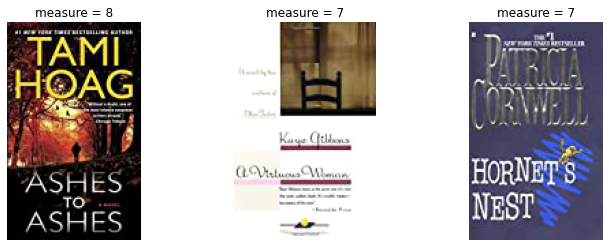

In [ ]:
T = Top(interactions)
T.top_items('tacoma, washington, united kingdom', 50)

# Рекомендации

На основе метода кластеризации похожих пользователей. Топ-10 рекомендаций с самой высокой оценкой. Считаем среднюю оценку для каждой книги по кластеру и выводим топ-10 книг.

In [ ]:
users_cluster = pd.pivot_table(interactions, values='Book-Rating', index='User-ID', columns='ISBN').reset_index()
users_cluster = users_cluster.fillna(0).astype('int64')
users_cluster

ISBN,User-ID,0002005018,0002251760,0002259834,0002558122,0006480764,000648302X,000649840X,0006546684,0006547834,0006550576,0006550789,0006551971,0006742939,0007110928,0007122039,0007141076,0007154615,000716226X,0007170866,0020125305,0020198817,0020198906,0020199600,002026478X,0020306652,0020360754,0020418809,0020427859,0020442009,0020442106,0020442203,0020442300,0020442408,0020442505,0020442602,0020446500,0020449313,0020518501,0020518609,...,8495501074,8495501090,8495501112,8495501198,8495501252,849550152X,8495618605,8804342838,8804370874,8804375914,8804470895,8806142100,8806143042,8807809907,880781000X,8807810212,880781076X,8807810778,880781210X,8807812576,8807813025,8807813823,8817106100,8817106259,8817131628,881787017X,8838910170,8838918600,8845205118,8845247414,8845407039,884590184X,8845915611,8885989403,9074336329,950491036X,9681500555,968150108X,9681501225,9726101794
0,8,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,114,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,242,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,243,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,278668,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10956,278694,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10957,278843,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10958,278851,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=20)
k_means.fit(users_cluster)
labels = k_means.labels_

In [ ]:
users_cluster['cluster'] = labels

In [ ]:
class Recomendation():
    def __init__(self, Int):
        self.product_id_to_url = {}
        for i in Int[["product_id", "picture_url"]].drop_duplicates().values:
            self.product_id_to_url[i[0]] = i[1]
        self.interactions = Int
        
    def top_items(self, cluster):
        index = users_cluster[users_cluster.cluster == cluster]['User-ID'].drop_duplicates().values
        items = (self.interactions[interactions['User-ID'].isin(index)]\
                 .groupby('product_id')['Book-Rating'].sum() / len(index))\
                 .reset_index()\
                 .sort_values('Book-Rating', ascending=False)[:10]
        rec_imaging(items["product_id"].values, self.product_id_to_url, items["Book-Rating"].values)

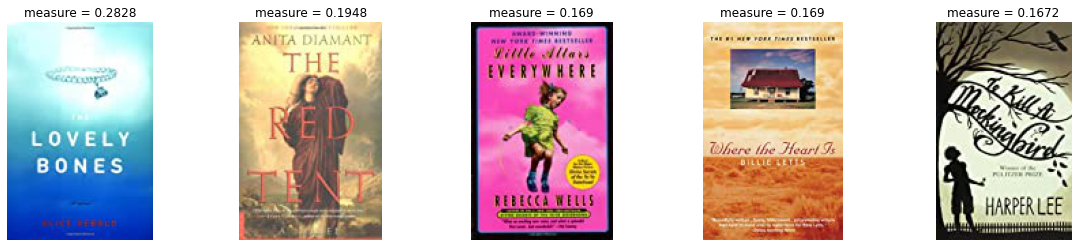

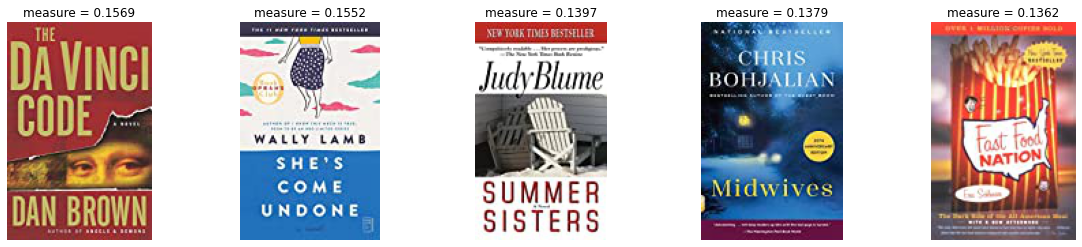

In [ ]:
Recomendation(interactions).top_items(0)

# Совстречаемость

Учитывать оценки. Вес пары книг встретившихся у пользователя - полусумма их оценок.

In [ ]:
class Recomendations():
    def __init__(self, Int):
        self.product_id_to_url = {}
        for i in Int[["product_id", "picture_url"]].drop_duplicates().values:
            self.product_id_to_url[i[0]] = i[1]
        self.interactions = Int
        
    def coocurrency_count(self):
        Int = self.interactions[["vid", "product_id", "Book-Rating"]].drop_duplicates()
        user_products = Int.groupby(["vid"])["product_id"].apply(list).reset_index()
        #добавляем рейтинг
        user_products["rating"] = Int.groupby("vid")["Book-Rating"].apply(list)
        product_num = [len(i) for i in user_products["product_id"]]
        user_products["prod_num"] = product_num
        user_products = user_products[user_products["prod_num"] > 1]
        
        cooc = {}
        #словарь под массивы весов книг
        rating = {}
        for i in tqdm.tqdm_notebook(user_products.values):
            for j in range(len(i[1])):
                for k in range(len(i[1])):
                    if j != k:
                        try:
                            cooc[str(i[1][j]) + "_" + str(i[1][k])] += 1
                        except:
                            cooc[str(i[1][j]) + "_" + str(i[1][k])] = 1
                            #полусумма оценок 
                            rating[str(i[1][j]) + "_" + str(i[1][k])] = (i[2][j] + i[2][k]) / 2
        cooc_list = []
        for i, j in cooc.items():
            if j != 1:
                cooc_list.append(i.split("_") + [j] + [rating[i]])
        self.cooc_rec = pd.DataFrame(cooc_list, columns=["item1", "item2", "measure", "rating"])
    
    def get_rec(self, i, show=False):
        recs = self.cooc_rec[self.cooc_rec["item1"] == str(i)]\
                            .sort_values(["measure", "rating"], ascending=False)\
                            .head(10)
        print(u"Для товара")
        rec_imaging([i], self.product_id_to_url)
        print(u"Такие рекомендации")
        rec_imaging(recs["item2"].values.astype(int), self.product_id_to_url, 
                         recs["rating"].values.astype(int))

In [ ]:
cooc_rec = Recomendations(interactions)
cooc_rec.coocurrency_count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10012 [00:00<?, ?it/s]

Для товара


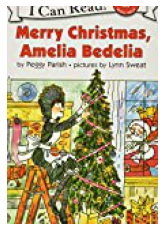

Такие рекомендации


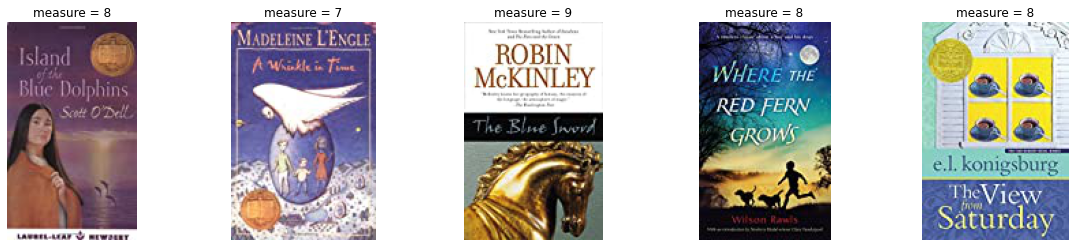

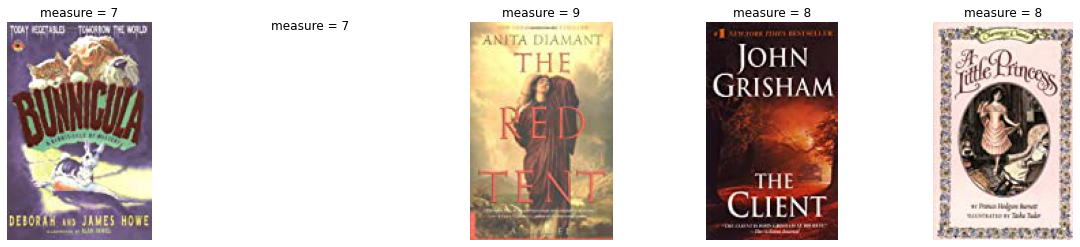

In [ ]:
cooc_rec.get_rec(100, True)

# Коллаборативная фильтрация

Реализовывать как на слайде 50 презентации, посоветовав каждому пользователю топ-10 книг с самой высокой оценкой. Сделать рекомендации User-based и Item-based и сравнить.

In [ ]:
class Colloborative():
    def __init__(self, interactions):
        self.content_dict = {}
        for i, j in interactions[["product_id", "picture_url"]].drop_duplicates().values:
            self.content_dict[int(i)] = j

        self.csr_rates = csr_matrix((interactions["Book-Rating"], (interactions["vid"], interactions["product_id"])),
                                    shape=(len(set(interactions["vid"])), len(set(interactions["product_id"]))))
        
    def user_based(self, idx):
        user_rates = self.csr_rates.getrow(idx).toarray()[0]
        watched_items = np.where(user_rates != 0)[0]
        metrics = cosine_similarity([user_rates], self.csr_rates).reshape(-1, 1)
        rates_mean = self.csr_rates.toarray().sum(axis=1) / np.diff(self.csr_rates.indptr)
        interaction = self.csr_rates.copy()
        interaction.data = np.ones_like(interaction.data)
        self.csr_rates = self.csr_rates - diags(rates_mean, 0) * interaction
        rates = csr_matrix.multiply(self.csr_rates.copy(), metrics)
        total_rate = (1 - user_rates.astype(bool)) * np.array(np.sum(rates, axis=0))[0]

        self.get_rec(watched_items, np.arange(self.csr_rates.shape[1])[np.argsort(total_rate)[::-1][:10]],
                    np.sort(total_rate)[::-1][:10])
        
    def item_based(self, idx):
        item_rates = self.csr_rates.getcol(idx).toarray().reshape(1, -1)
        metrics = cosine_similarity(item_rates, self.csr_rates.T).reshape(-1, 1)

        rates_mean = self.csr_rates.toarray().sum(axis=1) / np.diff(self.csr_rates.indptr)
        interaction = self.csr_rates.copy()
        interaction.data = np.ones_like(interaction.data)
        self.csr_rates = self.csr_rates - diags(rates_mean, 0) * interaction
        rates = csr_matrix.multiply(self.csr_rates.T.copy(), metrics)
        total_rate = np.array(np.sum(rates, axis=1)).ravel()

        self.get_rec([idx], np.arange(self.csr_rates.shape[1])[np.argsort(total_rate)[::-1][:10]],
                    np.sort(total_rate)[::-1][:10])

    def get_rec(self, watched, recs, measure):
        print(u"Для таких товаров")
        rec_imaging([i for i in watched], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging([i for i in recs], self.content_dict, measure)

Colloborative_Filter = Colloborative(interactions)

Для таких товаров


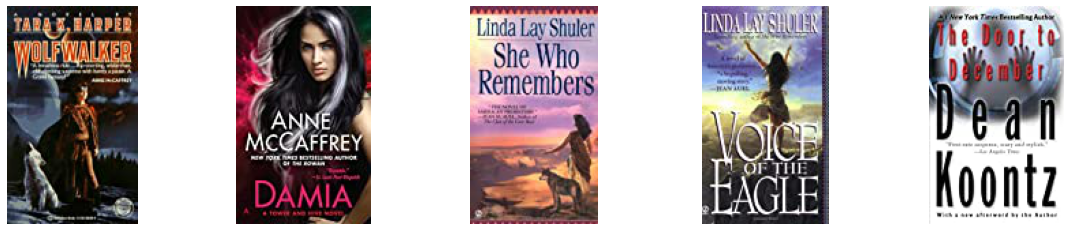

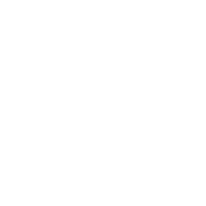

Такие рекомендации


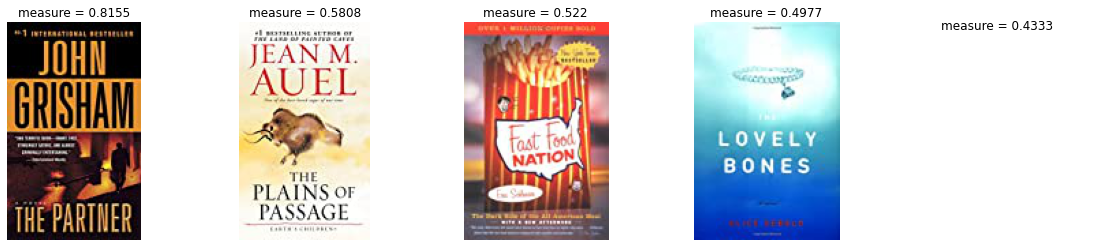

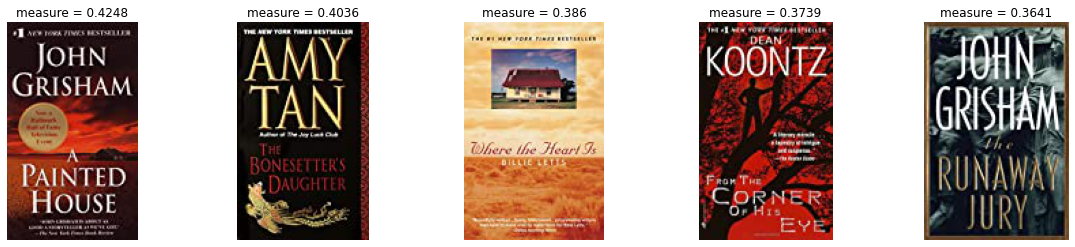

In [ ]:
Colloborative_Filter.user_based(100)

Для таких товаров


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


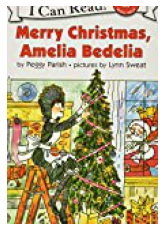

Такие рекомендации


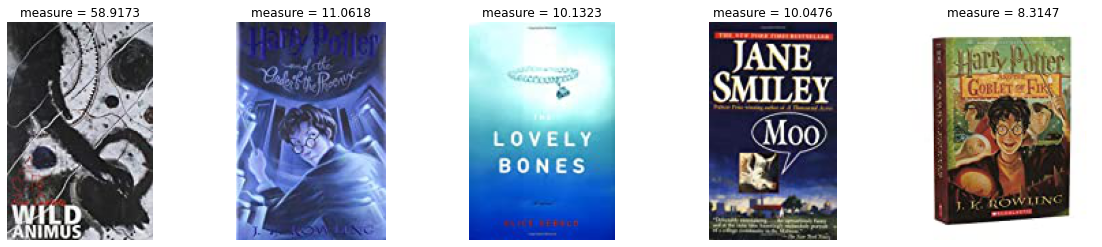

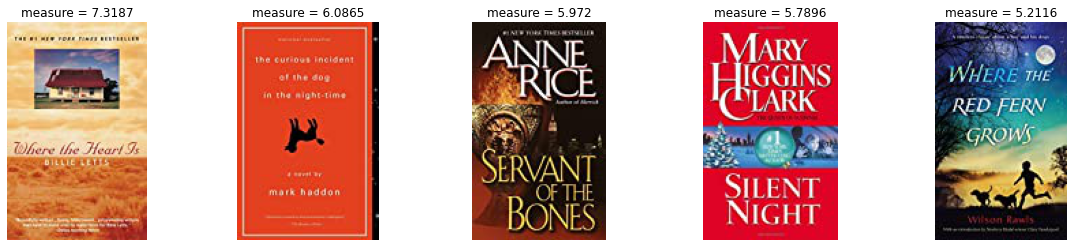

In [ ]:
Colloborative_Filter.item_based(100)